# Comparing real hyy observations to emcmc strategies and enkf alone

In [1]:
from glob import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fatescal.tools import metrics
from fatescal.tools import unit_conversion as uc
from fatescal.config import VARIABLES_TO_ASSIMILATE, \
    PROJECT_ROOT_PATH

In [2]:
# Tell pandas to display more float digits to explore small values
pd.options.display.float_format = '{:,.10f}'.format

In [57]:
# TARGET VARIABLE PATHS
result_dir_path = PROJECT_ROOT_PATH / 'data' / 'results'
aligned_dir_path = result_dir_path / 'aligned_obs_model'

color_json_path = result_dir_path.parent / 'dict'
with open(
    color_json_path / 'color_dict.json',
    'r'
) as color_json:
    color_dict = json.load(color_json)


plot_save_path = result_dir_path / 'plots' / 'publication_results' / 'hyy_real'
if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True)

result_paths: dict = {
    'K4': aligned_dir_path / 'HYY_REAL_n128_K4_1D_gpp_et' / 'kalman_iter_4',
    'CES_EC': aligned_dir_path / 'HYY_REAL_n128_K4_1D_gpp_et' / 'mcmc',
    'UNI_EC': aligned_dir_path / 'HYY_REAL_n256_uniform_1D_gpp_et' / 'mcmc',
    'LHC_EC': aligned_dir_path / 'HYY_REAL_n256_lhc_1D_gpp_et' / 'mcmc',
    'LON_EC': aligned_dir_path / 'HYY_REAL_n256_lon_1D_gpp_et' / 'mcmc',
    'default': aligned_dir_path / 'HYY_default_1D_gpp_et' / 'kalman_iter_0',
}

# PARAMETER PATHS

chain_dir_path = result_dir_path / 'mcmc_chains'
chain_name = 'mcmc_chain_pruned.csv'

mcmc_chain_paths: dict = {
    'K4': result_dir_path / 'fates_param_ensembles'/ 'HYY_REAL_n128_K4_1D_gpp_et' / \
    'csv' / 'kalman_iter_4' / 'ces_n128_vcmax_bbslope.csv',
    'CES_EC': chain_dir_path / 'HYY_REAL_n128_K4_1D_gpp_et' / chain_name,
    'UNI_EC': chain_dir_path / 'HYY_REAL_n256_uniform_1D_gpp_et' / chain_name,
    'LHC_EC': chain_dir_path / 'HYY_REAL_n256_lhc_1D_gpp_et' / chain_name,
    'LON_EC': chain_dir_path / 'HYY_REAL_n256_lon_1D_gpp_et' / chain_name,
}


In [5]:
# Retrieve variable names
obs_var_names = [
    x['Observed']['csv_col_name']for x in VARIABLES_TO_ASSIMILATE
]
model_var_names = [
    x['CLM-FATES']['history_var_name'] for x in VARIABLES_TO_ASSIMILATE
]

In [14]:
# Read observation data
obs_glob = sorted(glob(str(
    next(iter(result_paths.values())) / 'O_*.csv'
)))[0]  # Identical observation DataFrame in each result, use first

obs_df = pd.read_csv(obs_glob)

# Convert time to datetime
obs_df['samptime'] = pd.to_datetime(
    obs_df['samptime']
)

# Convert units to readable numbers
for var in obs_var_names:
    obs_df[var] = uc.convert_unit(
        values=obs_df[var],
        unit_in='kg s-1',
        unit_out='g d-1'
    )
obs_df["ET_gapf"] = \
    obs_df["ET_gapf"] / 1000 # from g to kg

In [15]:
# Read model data
ensembles: list = []

for ensemble_path in result_paths.values():

    model_globs = sorted(glob(str(
        ensemble_path / 'M_*.csv'
    )))

    current_df_list = []

    for model_glob in model_globs:

        cur_df = pd.read_csv(model_glob)

        # Convert to datetime
        cur_df['time'] = pd.to_datetime(cur_df['time'])

        # Convert to readable units
        for var in model_var_names:
            cur_df[var] = uc.convert_unit(
                values=cur_df[var],
                unit_in='kg s-1',
                unit_out='g d-1'
            )
        cur_df["QFLX_EVAP_TOT"] = \
            cur_df["QFLX_EVAP_TOT"] / 1000 # from g to kg

        current_df_list.append(cur_df)
    
    ensembles.append(current_df_list)

In [16]:
# CALCULATE ENSEMBLE MEAN AND RANGE

ensemble_stats_dfs: list = []

for ensemble in ensembles:

    cur_df = pd.DataFrame()

    for var in model_var_names:
        mean, max, min = metrics.ensemble_mean_max_min(
            ensemble_df_list=ensemble,
            column_name=var,
        )

        cur_df[var+"_mean"] = mean
        cur_df[var+"_max"] = max
        cur_df[var+"_min"] = min
    
    ensemble_stats_dfs.append(cur_df)

In [49]:
label_dict = {
    'Observed': 'Observed',
    'K4': 'K$_4$',
    'CES_EC': 'CES$_{\mathrm{EC}}$',
    'UNI_EC': 'UNI$_{\mathrm{EC}}$',
    'LHC_EC': 'LHS$_{\mathrm{EC}}$',
    'LON_EC': 'LON$_{\mathrm{EC}}$',
    'default': 'Default'
}

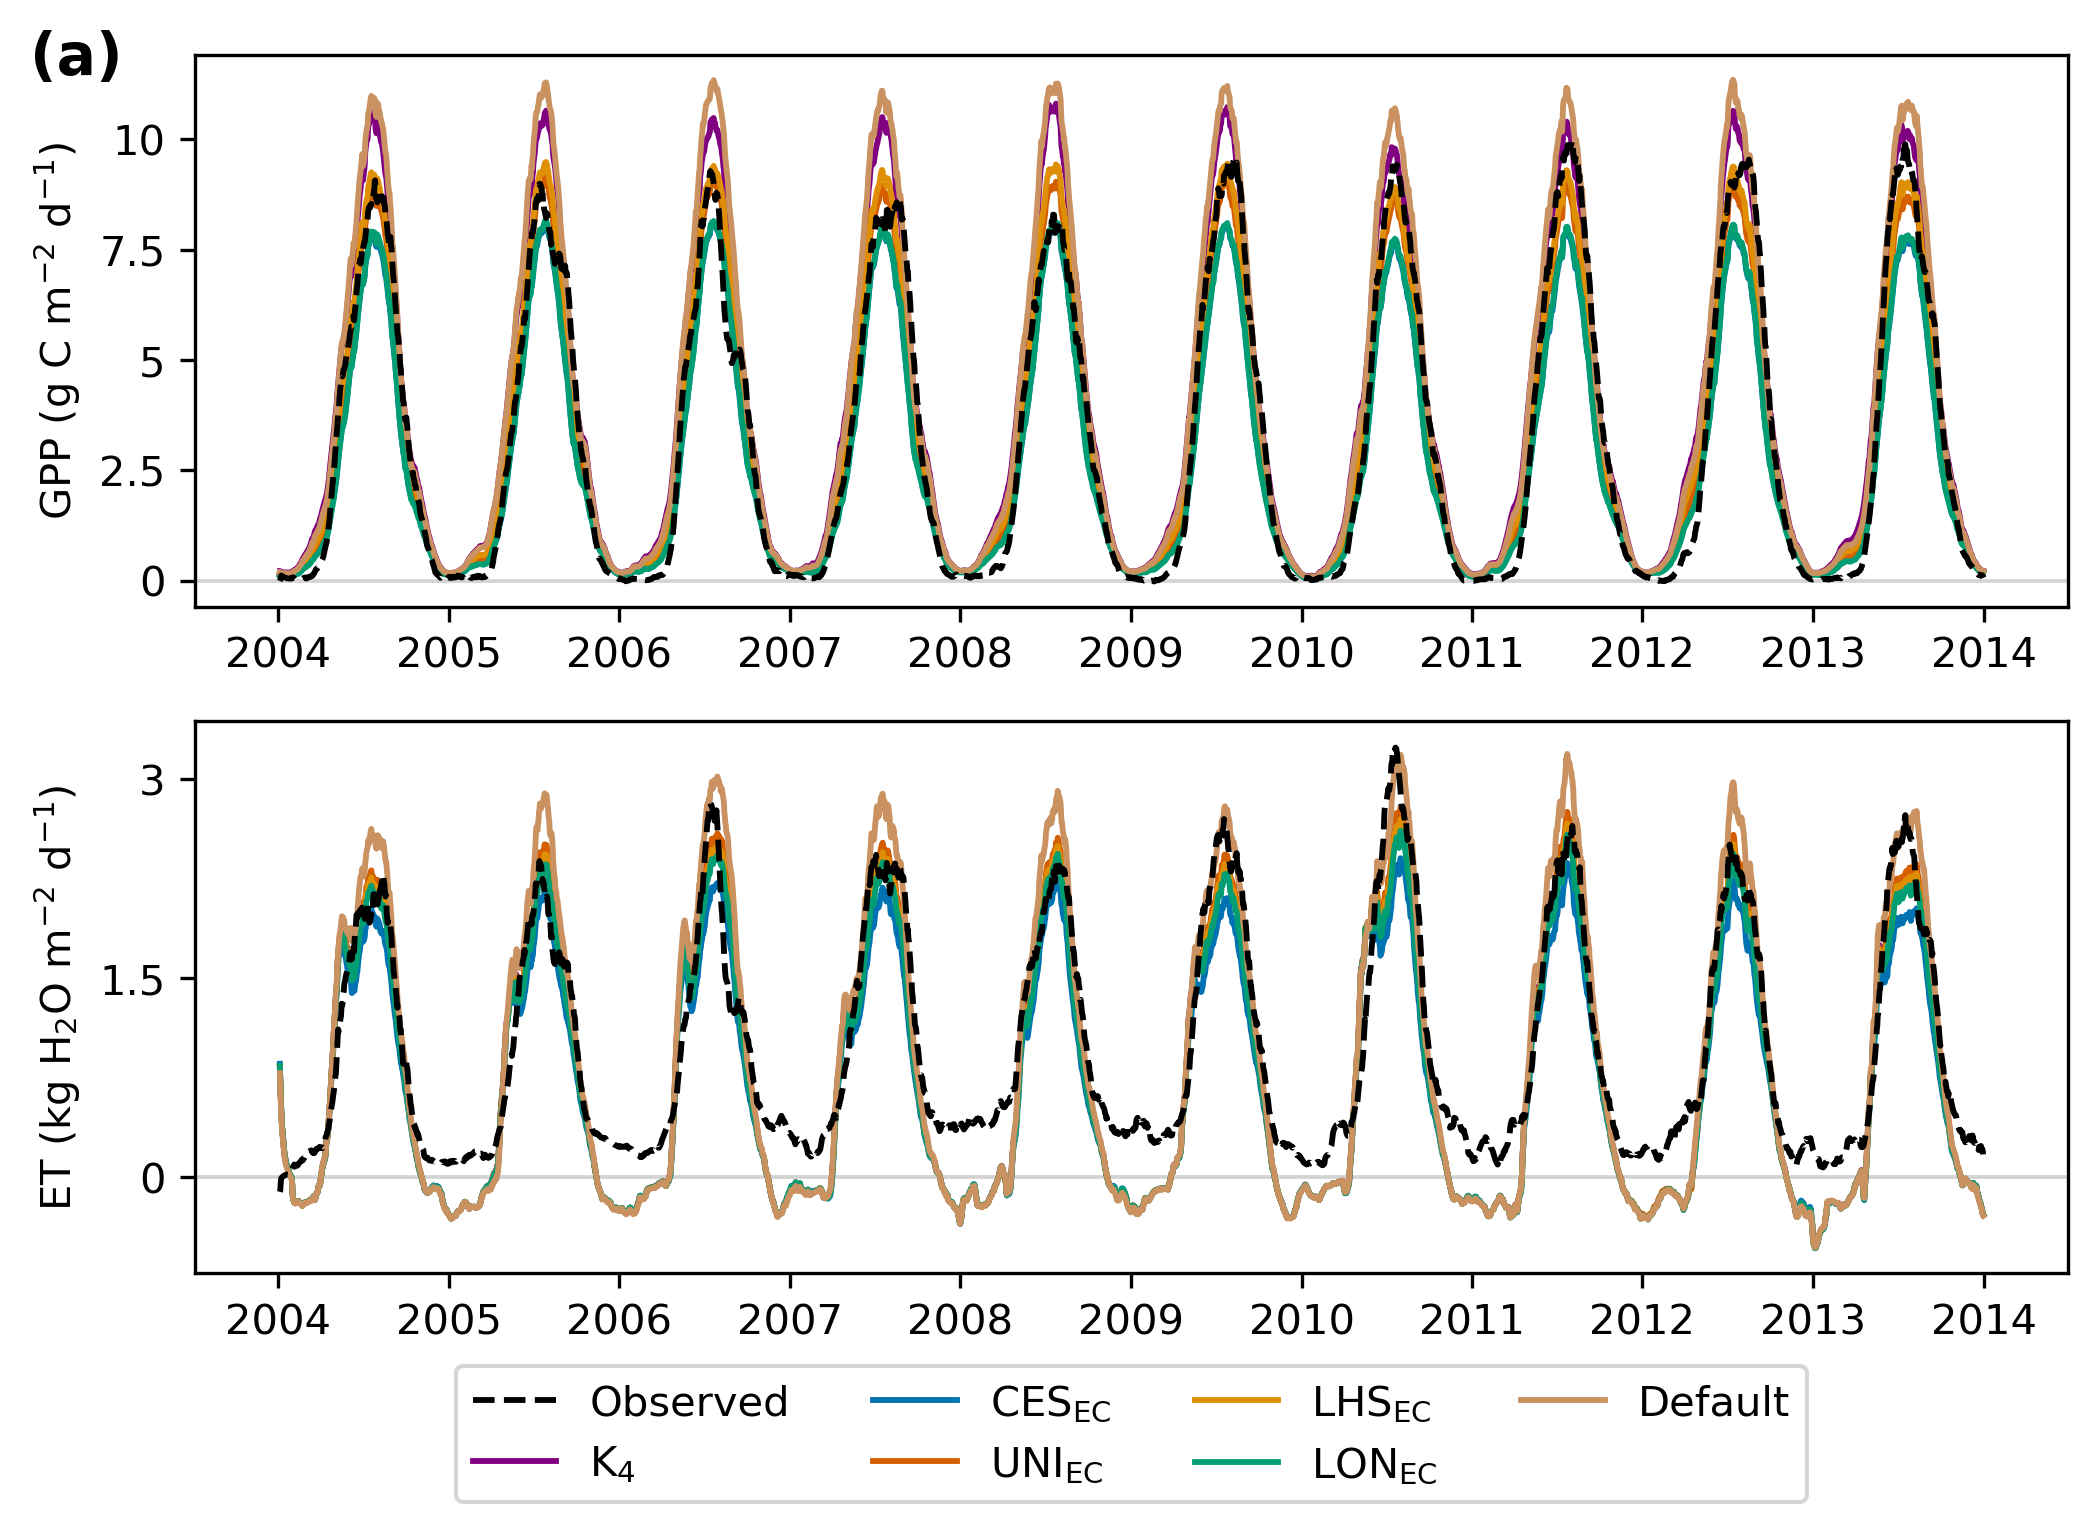

In [78]:
# PLOT TIME SERIES

save_fig = True
window_size = 30  # Rolling average, in days
obs_color = "black"#"#FF000D"
alpha = 1
line_width = 1.4

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(18/2.54, 13/2.54),
    dpi=300
)

# Observed GPP
axes[0].plot(
    obs_df["samptime"],
    obs_df["GPP"].rolling(window=window_size, min_periods=5).mean(),
    linewidth=line_width,
    alpha=1,
    color=obs_color,
    linestyle="dashed",
    label=label_dict["Observed"],
    zorder=2,
)

# Observed ET
axes[1].plot(
    obs_df["samptime"],
    obs_df["ET_gapf"].rolling(window=window_size, min_periods=5).mean(),
    linewidth=line_width,
    alpha=1,
    color=obs_color,
    linestyle="dashed",
    label=label_dict["Observed"],
    zorder=2,
)

for experiment_name, stats_df in zip(
    result_paths.keys(),
    ensemble_stats_dfs
):
    # PLOT GPP

    # Observations
    axes[0].plot(
        obs_df["samptime"],
        stats_df["FATES_GPP_mean"].rolling(window=window_size, min_periods=5).mean(),
        linewidth=line_width,
        alpha=alpha,
        color=color_dict[experiment_name],
        label=label_dict[experiment_name],
        zorder=1,
    )

    # Observed ET
    axes[1].plot(
        obs_df["samptime"],
        stats_df["QFLX_EVAP_TOT_mean"].rolling(window=window_size, min_periods=5).mean(),
        linewidth=line_width,
        alpha=alpha,
        color=color_dict[experiment_name],
        label=label_dict[experiment_name],
        zorder=1,
    )

axes[0].set_ylabel(
    "GPP (g C m$^{-2}$ d$^{-1}$)"
)
axes[1].set_ylabel(
    "ET (kg H$_2$O m$^{-2}$ d$^{-1}$)"
)

#axes[0].legend(ncols=2)

fig.text(
    0.02, 0.95,
    "(a)",
    ha='left',
    va='bottom',
    #transform=ax.transAxes,
    fontsize=14,
    fontweight='demibold',
)

axes[0].set_yticks([0, 2.5, 5, 7.5, 10])
axes[0].set_yticklabels([0, 2.5, 5, 7.5, 10])

axes[1].set_yticks([0, 1.5, 3])
axes[1].set_yticklabels([0, 1.5, 3])

# Put a legend below current axis
axes[1].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.13),
    ncol=4
)

# Add line at y=0
axes[0].axhline(
    y=0, linestyle='-', linewidth=0.9, color='lightgray',
    zorder=-1
)
axes[1].axhline(
    y=0, linestyle='-', linewidth=0.9, color='lightgray',
    zorder=-1
)

fig.tight_layout()

if save_fig:
    fig.savefig(
        plot_save_path / f'real_{window_size}d_avg_time_series.png'
    )

---
## RMSE

In [20]:
# Calculate RMSE stats
from fatescal.tools import metrics

targets = ["GPP", "ET"]
metric_names = [
    "rmse_mean", "rmse_sd",
    "r2_mean", "r2_sd",
    "bias_mean", "bias_sd",
]
ensemble_stats_df = pd.DataFrame(
    columns=[x+"_"+y for x in targets for y in metric_names]
)

for experiment_name, df_list in zip(
    result_paths.keys(),
    ensembles
):

    # GPP
    ensemble_stats_df.loc[experiment_name, 0:len(metric_names)] = \
        metrics.get_ensemble_error_metrics(
            ensemble_df_list=df_list,
            col_name="FATES_GPP",
            actual=obs_df['GPP'].values,
        )

    # ET
    ensemble_stats_df.loc[experiment_name, len(metric_names):] = \
        metrics.get_ensemble_error_metrics(
            ensemble_df_list=df_list,
            col_name="QFLX_EVAP_TOT",
            actual=obs_df['ET_gapf'].values,
        )

ensemble_stats_df

/tmp/ipykernel_3284699/1544794875.py:20: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ensemble_stats_df.loc[experiment_name, 0:len(metric_names)] = \
/tmp/ipykernel_3284699/1544794875.py:28: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ensemble_stats_df.loc[experiment_name, len(metric_names):] = \
/tmp/ipykernel_3284699/1544794875.py:20: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ensemble_stats_df.loc[experiment_name, 0:len(metric_names)] = \
/tmp/ipykernel_3284699/1544794875.py:28: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc 

,GPP_rmse_mean,GPP_rmse_sd,GPP_r2_mean,GPP_r2_sd,GPP_bias_mean,GPP_bias_sd,ET_rmse_mean,ET_rmse_sd,ET_r2_mean,ET_r2_sd,ET_bias_mean,ET_bias_sd
K4,1.5493113841,0.0262378161,0.8574497479,0.0008581616,-0.6786131781,0.0338724096,0.6489223664,0.0003853021,0.6656142563,0.0003668586,0.2201310973,0.0015341510
CES_EC,1.3979900790,0.0261506281,0.8721408033,0.0007054080,0.4264388038,0.0460647830,0.6612074930,0.0024791881,0.6502384257,0.0018766984,0.3074672095,0.0087840175
UNI_EC,1.2645546134,0.0028373499,0.8693441845,0.0003430475,0.0512932430,0.0373597802,0.6509729534,0.0005407696,0.6703927738,0.0011355902,0.2141533930,0.0059050309
LHC_EC,1.2813062784,0.0078021647,0.8665283448,0.0005842142,-0.1457335638,0.0424553735,0.6492089083,0.0003207379,0.6660110853,0.0012837925,0.2291241622,0.0065275355
LON_EC,1.3858579319,0.0261095864,0.8729852562,0.0003978962,0.4272670305,0.0457419655,0.6494026135,0.0008976571,0.6630304789,0.0018743992,0.2514119295,0.0085209713
default,1.6717084576,0.0000000000,0.8591064460,0.0000000000,-0.7807336019,0.0000000000,0.6870814960,0.0000000000,0.6844944034,0.0000000000,0.1078862122,0.0000000000


In [86]:
ensemble_stats_df = ensemble_stats_df.style.format(
    decimal='.', thousands=',', precision=2
)
latex_str = ensemble_stats_df.to_latex()
print(latex_str)

\begin{tabular}{lllllllllllll}
 & GPP_rmse_mean & GPP_rmse_sd & GPP_r2_mean & GPP_r2_sd & GPP_bias_mean & GPP_bias_sd & ET_rmse_mean & ET_rmse_sd & ET_r2_mean & ET_r2_sd & ET_bias_mean & ET_bias_sd \\
K4 & 1.55 & 0.03 & 0.86 & 0.00 & -0.68 & 0.03 & 0.65 & 0.00 & 0.67 & 0.00 & 0.22 & 0.00 \\
CES_EC & 1.40 & 0.03 & 0.87 & 0.00 & 0.43 & 0.05 & 0.66 & 0.00 & 0.65 & 0.00 & 0.31 & 0.01 \\
UNI_EC & 1.26 & 0.00 & 0.87 & 0.00 & 0.05 & 0.04 & 0.65 & 0.00 & 0.67 & 0.00 & 0.21 & 0.01 \\
LHC_EC & 1.28 & 0.01 & 0.87 & 0.00 & -0.15 & 0.04 & 0.65 & 0.00 & 0.67 & 0.00 & 0.23 & 0.01 \\
LON_EC & 1.39 & 0.03 & 0.87 & 0.00 & 0.43 & 0.05 & 0.65 & 0.00 & 0.66 & 0.00 & 0.25 & 0.01 \\
default & 1.67 & 0.00 & 0.86 & 0.00 & -0.78 & 0.00 & 0.69 & 0.00 & 0.68 & 0.00 & 0.11 & 0.00 \\
\end{tabular}



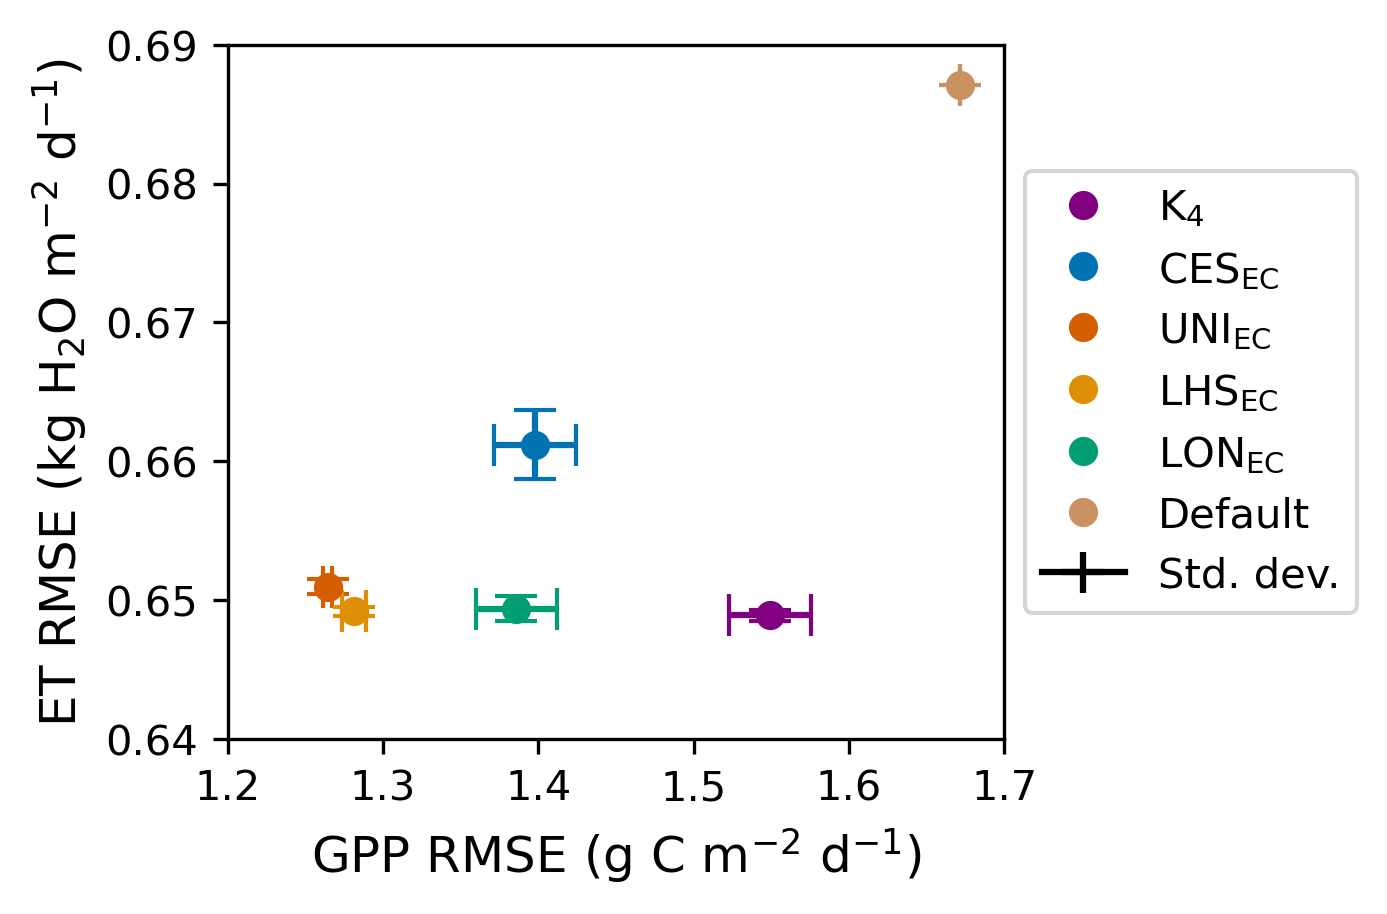

In [77]:
# Create plot
# Plot
save_fig = True
plot_size_cm = 8

fig, ax = plt.subplots(
    figsize=(12/2.54, plot_size_cm/2.54),
    dpi=300
)

for experiment_name in result_paths.keys():
    
    ax.errorbar(
        x=ensemble_stats_df.loc[experiment_name, "GPP_rmse_mean"],
        y=ensemble_stats_df.loc[experiment_name, "ET_rmse_mean"],
        xerr=ensemble_stats_df.loc[experiment_name, "GPP_rmse_sd"],#xerr,
        yerr=ensemble_stats_df.loc[experiment_name, "ET_rmse_sd"],#yerr,
        fmt='o',
        ms=6,
        label=label_dict[experiment_name],
        color=color_dict[experiment_name],
        capsize=5,
    )

ax.set_xlabel(
    "GPP RMSE (g C m$^{-2}$ d$^{-1}$)",
    fontsize=12
)
ax.set_ylabel(
    "ET RMSE (kg H$_{2}$O m$^{-2}$ d$^{-1}$)",
    fontsize=12
)

# Dummy errorbar
ax.errorbar(
    x=[],
    y=[],
    xerr=[1],
    yerr=[1],
    fmt='-',
    color="black",
    label="Std. dev.",
    capsize=2,
)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
from matplotlib import container
handles[:-1] = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles[:-1]]

ax.legend(
    handles=handles,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

'''
fig.text(
    0.03, 0.03,
    "(b)",
    ha='left',
    va='bottom',
    #transform=ax.transAxes,
    fontsize=14,
    fontweight='demibold',
)
'''

ax.set_yticks([0.64, 0.65, 0.66, 0.67, 0.68, 0.69])
ax.set_yticklabels([0.64, 0.65, 0.66, 0.67, 0.68, 0.69])

ax.set_xticks([1.2, 1.3, 1.4, 1.5, 1.6, 1.7])
ax.set_xticklabels([1.2, 1.3, 1.4, 1.5, 1.6, 1.7])

fig.tight_layout()

if save_fig:
    fig.savefig(
        plot_save_path / 
        f"real_RMSE_comparison.png",
        dpi=300
    )

---
## Plot parameter distributions

In [23]:
parameter_df_list = [
    pd.read_csv(x) for x in mcmc_chain_paths.values()
]

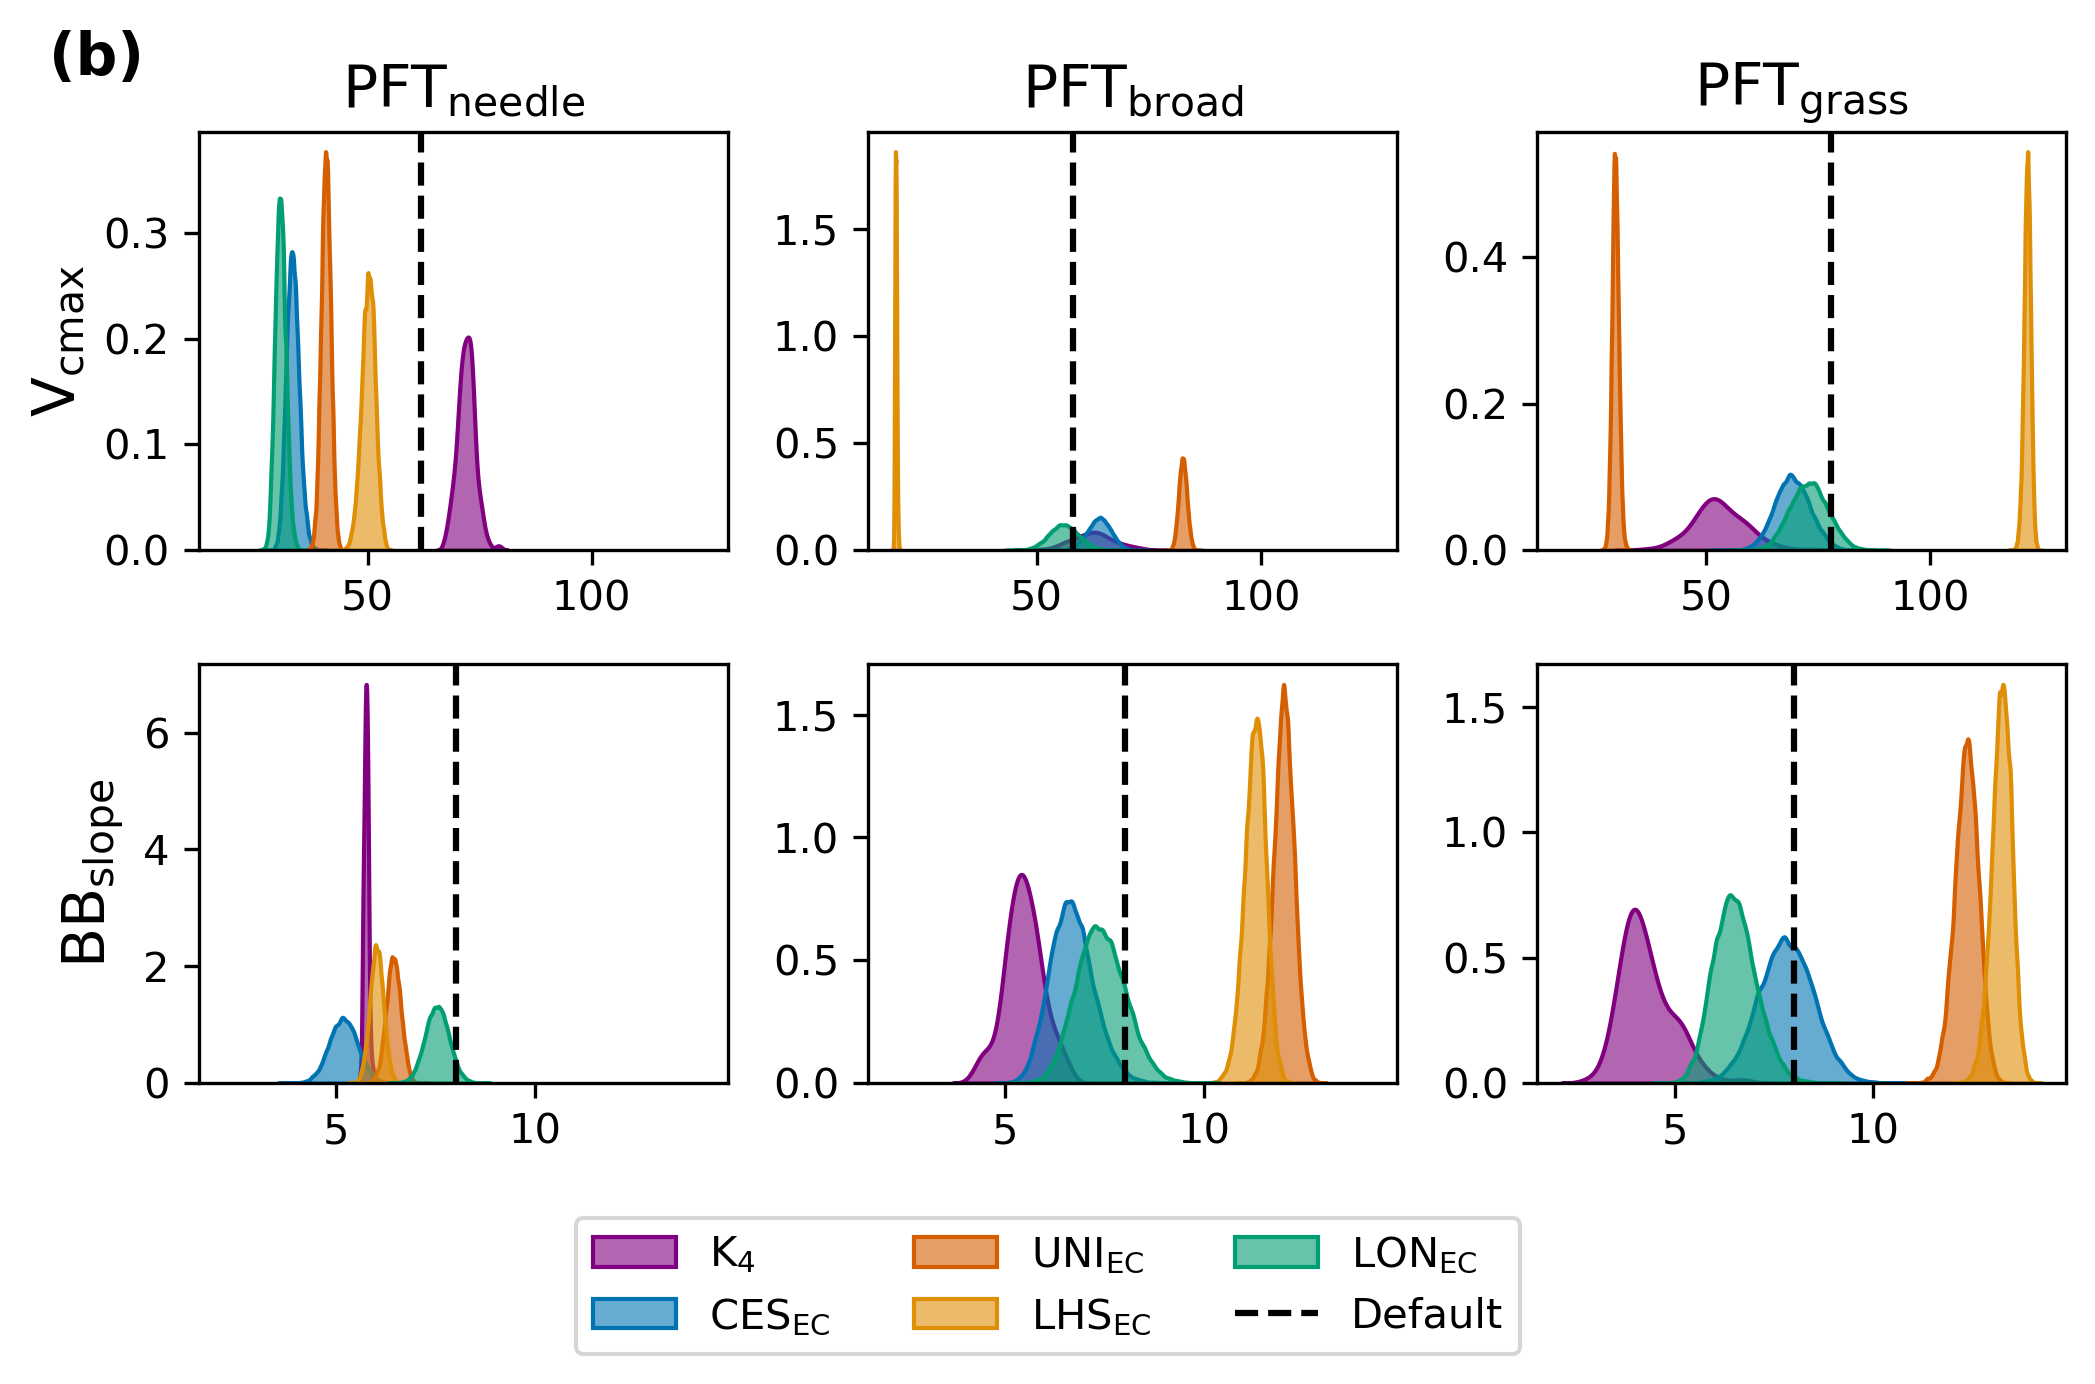

In [83]:
save_fig = True

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    sharey=False,
    sharex='row',
    figsize=(18/2.54, 10/2.54),
    dpi=300,
)

for df, exp_name in zip(parameter_df_list, mcmc_chain_paths.keys()):

    # Density plot Vcmax
    for idx, pft_idx in enumerate(["2", "6", "11"]):
        # Vcmax
        sns.kdeplot(
            data=df["fates_leaf_vcmax25top_PFT"+pft_idx],
            ax=axes[0, idx],
            fill=True,
            alpha=0.6,
            legend=False,
            label=label_dict[exp_name],
            color=color_dict[exp_name],
        )
        axes[0, idx].set_ylabel("")
        axes[0, idx].set_xlabel("")

        # BBslope
        sns.kdeplot(
            data=df["fates_leaf_stomatal_slope_ballberry_PFT"+pft_idx],
            ax=axes[1, idx],
            fill=True,
            alpha=0.6,
            legend=False,
            label=label_dict[exp_name],
            color=color_dict[exp_name],
        )
        axes[1, idx].set_ylabel("")
        axes[1, idx].set_xlabel("")

axes[0, 0].set_title("PFT$_{\mathrm{needle}}$", fontsize=14)
axes[0, 1].set_title("PFT$_{\mathrm{broad}}$", fontsize=14)
axes[0, 2].set_title("PFT$_{\mathrm{grass}}$", fontsize=14)

axes[0, 0].set_ylabel("V$_{\mathrm{cmax}}$", fontsize=14)
axes[1, 0].set_ylabel("BB$_{\mathrm{slope}}$", fontsize=14)

# Plot default values
# VCMAX
axes[0, 0].axvline(x=62, linestyle='dashed', color="black", label='Default')
axes[0, 1].axvline(x=58, linestyle='dashed', color="black", label='Default')
axes[0, 2].axvline(x=78, linestyle='dashed', color="black", label='Default')
# BBSLOPE
axes[1, 0].axvline(x=8, linestyle='dashed', color="black", label='Default')
axes[1, 1].axvline(x=8, linestyle='dashed', color="black", label='Default')
axes[1, 2].axvline(x=8, linestyle='dashed', color="black", label='Default')

handles, fig_labels = axes[0, 0].get_legend_handles_labels()

fig.legend(
    handles,
    fig_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0),
    fontsize=10,
    ncol=3
)

#axes[0, 2].legend()

fig.tight_layout()

fig.text(
    0.03, 0.94,
    "(b)",
    ha='left',
    va='bottom',
    #transform=ax.transAxes,
    fontsize=14,
    fontweight='demibold',
)

if save_fig:
    fig.savefig(
        plot_save_path / 'real_mcmc_strategy_kdeplots.png',
        bbox_inches='tight',
    )